In [2]:
!sudo pip install imbalanced-learn
!unzip /content/abc.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Archive:  /content/abc.zip
  inflating: SampleSubmission.csv    
  inflating: Test.csv                
  inflating: VariableDefinitions.csv  
  inflating: R_StarterNotebook.ipynb  
  inflating: Python_StarterNotebook.ipynb  
  inflating: Train.csv               
  inflating: NigerianStateNames.csv  


# AutoInland Vehicle Insurance Claim Challenge

In [3]:
#importing libraries

import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import warnings
from imblearn.under_sampling import RandomUnderSampler
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

#### Read Files

In [4]:
#read both train and test data
train=pd.read_csv("/content/Train.csv")
test=pd.read_csv("/content/Test.csv")
test_f=test[['ID']]

n_train=train.shape[0]
print("Size of train set: ",n_train)
n_test=test.shape[0]
print("Size of test set: ",n_test)
train.head()

Size of train set:  12079
Size of test set:  1202


,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [5]:
#variable definitions
definitions=pd.read_csv("/content/VariableDefinitions.csv")
definitions

,ID,Unique ID for the customer
0,Policy Start Date,Date policy started
1,Policy End Date,Date policy ended
2,Gender,Gender of the customer
3,Age,Age of the customer
4,ProductName,Name of Insurance policy
5,First Transaction Date,First date payment was made
6,No_Pol,Number of policies the customer has
7,Car_Category,Type of car
8,Subject_Car_Colour,Car colour
9,Subject_Car_Make,Car make


#### Data Description

In [6]:
# Function that produces the description of the data

def check(data,set_name):
    print("{}set".format(set_name))
    print('='*100)
    print('='*100)
    print(" ")
    print("shape: ",data.shape)
    print(" ")
    print('='*100)
    print('data describe')
    print(data.describe())
    print('='*100)
    print(" ")
    print('info' ) 
    data.info()
    print('='*100)
    print(" ")
    print('='*100)


In [7]:
# Train data

check(train,'train')

trainset
 
shape:  (12079, 14)
 
data describe
                Age        No_Pol        target
count  12079.000000  12079.000000  12079.000000
mean      42.234539      1.307227      0.120457
std       97.492565      0.733085      0.325509
min    -6099.000000      1.000000      0.000000
25%       35.000000      1.000000      0.000000
50%       41.000000      1.000000      0.000000
75%       50.000000      1.000000      0.000000
max      320.000000     10.000000      1.000000
 
info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      12079 non-null  object
 1   Policy Start Date       12079 non-null  object
 2   Policy End Date         12079 non-null  object
 3   Gender                  11720 non-null  object
 4   Age                     12079 non-null  int64 
 5   First Transaction Date  12079 non-nu

In [8]:
# Test data
check(test,'test')


testset
 
shape:  (1202, 13)
 
data describe
               Age       No_Pol
count  1202.000000  1202.000000
mean     43.792845     1.257903
std      19.986245     0.613510
min     -26.000000     1.000000
25%      35.000000     1.000000
50%      41.000000     1.000000
75%      50.000000     1.000000
max     120.000000     7.000000
 
info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      1202 non-null   object
 1   Policy Start Date       1202 non-null   object
 2   Policy End Date         1202 non-null   object
 3   Gender                  1161 non-null   object
 4   Age                     1202 non-null   int64 
 5   First Transaction Date  1202 non-null   object
 6   No_Pol                  1202 non-null   int64 
 7   Car_Category            830 non-null    object
 8   Subject_Car_Colour      505 

In [9]:
# Specify numerical and categorical variables

cat_col=train.select_dtypes(include=['object']).columns.tolist()
num_col=train.select_dtypes(exclude=['object']).columns.tolist()
print('numerical columns: ',num_col)
print('categorical columns: ',cat_col)

numerical columns:  ['Age', 'No_Pol', 'target']
categorical columns:  ['ID', 'Policy Start Date', 'Policy End Date', 'Gender', 'First Transaction Date', 'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State', 'ProductName']


#### Data Cleaning

In [10]:
# Change each column to its appriopriate datatype

def change_type(data):
    date_cols = [col for col in data.columns if 'Date' in col]
    num_cols = ['Age', 'No_Pol']
    cat_cols = [col for col in data.columns if col not in date_cols+num_cols+['ID', 'target']]

    for col in data.columns:
        if col in date_cols:
            data[col] = pd.to_datetime(data[col])
        elif col in cat_cols:
            data[col] = data[col].astype('category')

    
    data.info()

In [11]:
# Change and confirm whether the changes have been applied successfully

change_type(train)
change_type(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      12079 non-null  object        
 1   Policy Start Date       12079 non-null  datetime64[ns]
 2   Policy End Date         12079 non-null  datetime64[ns]
 3   Gender                  11720 non-null  category      
 4   Age                     12079 non-null  int64         
 5   First Transaction Date  12079 non-null  datetime64[ns]
 6   No_Pol                  12079 non-null  int64         
 7   Car_Category            8341 non-null   category      
 8   Subject_Car_Colour      5117 non-null   category      
 9   Subject_Car_Make        9603 non-null   category      
 10  LGA_Name                5603 non-null   category      
 11  State                   5591 non-null   category      
 12  ProductName             12079 non-null  catego

#### Check for missing values across the data

In [12]:
# A function that checks for missing values

def missing_data(data,set_name):
   
    ax = data.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
    plt.title('Percentage of Missing Values Per Column in {} set with {} rows'.format(set_name,data.shape[0]), fontdict={'size':15})
    for p in ax.patches:
        percentage ='{:,.0f}%'.format((p.get_width()/data.shape[0])*100)
        width, height =p.get_width(),p.get_height()
        x=p.get_x()+width+0.02
        y=p.get_y()+height/2
        ax.annotate(percentage,(x,y))

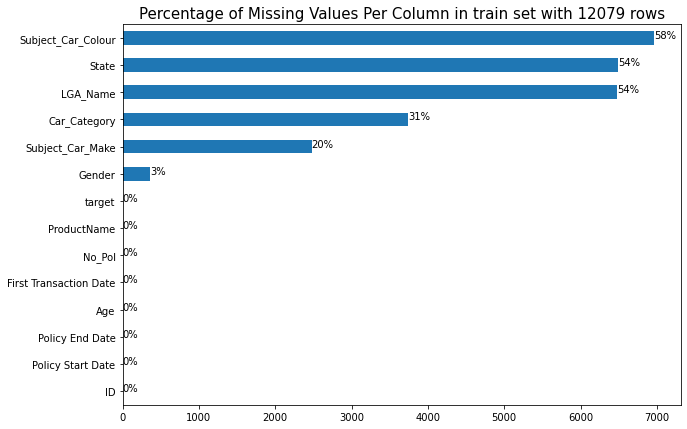

In [13]:
missing_data(train,'train')

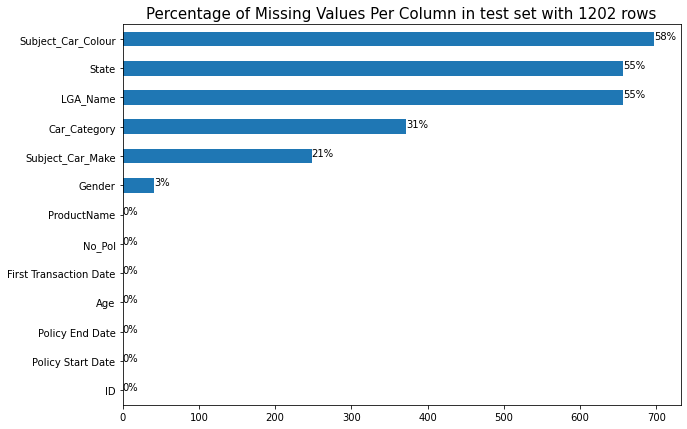

In [14]:
missing_data(test,'test')

# EDA

#### Target distribution

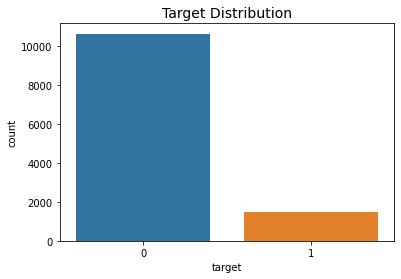

In [15]:
# Check how the target variable is distributed 

sns.countplot(train.target)
plt.title('Target Distribution', fontdict={'size':14});

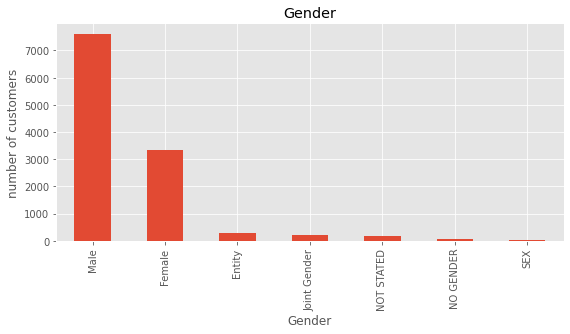

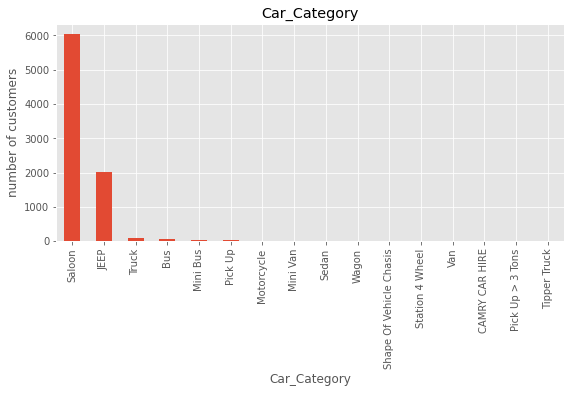

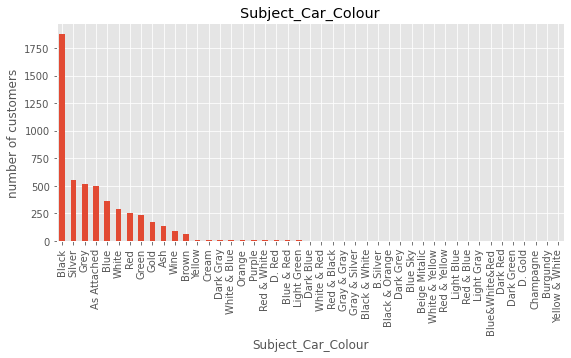

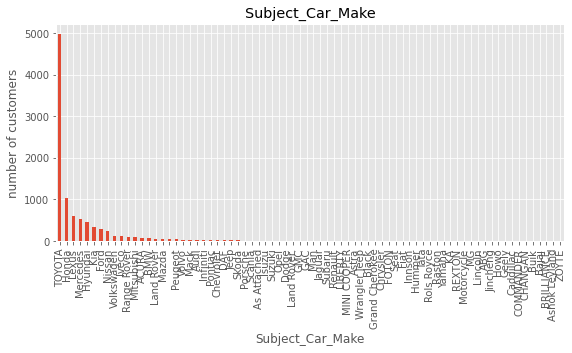

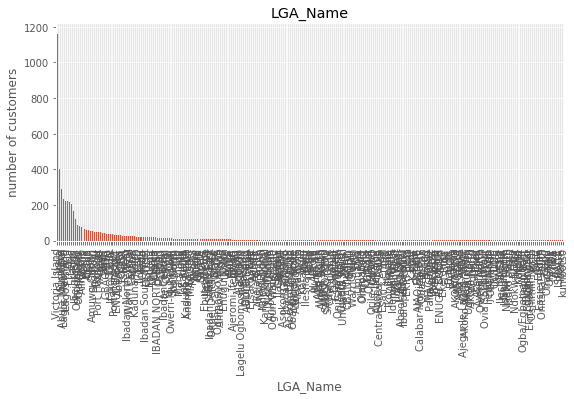

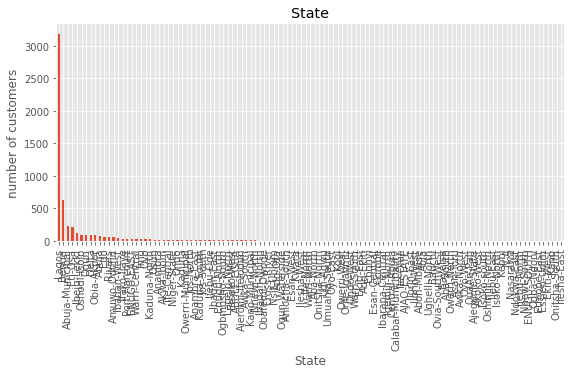

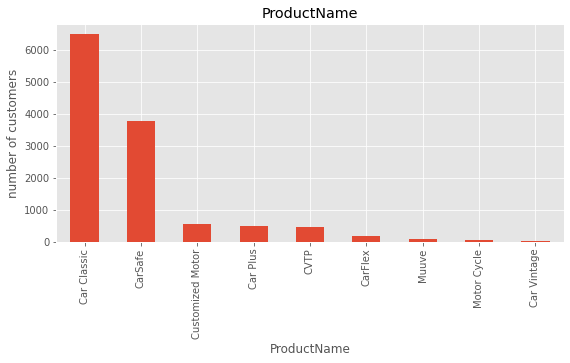

In [16]:
# Plotting bar charts for each categorical variables

cat_c=['Gender',  'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State', 'ProductName']
plt.style.use("ggplot")
def univariate_plot(data,cols):
    for column in cols:
        plt.figure(figsize=(20,4))
        plt.subplot(121)
        data[column].value_counts().plot(kind="bar")
        plt.xlabel(column)
        plt.ylabel("number of customers")
        plt.title(column)
univariate_plot(train,cat_c)        

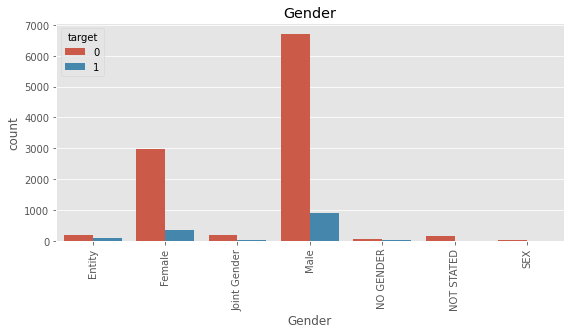

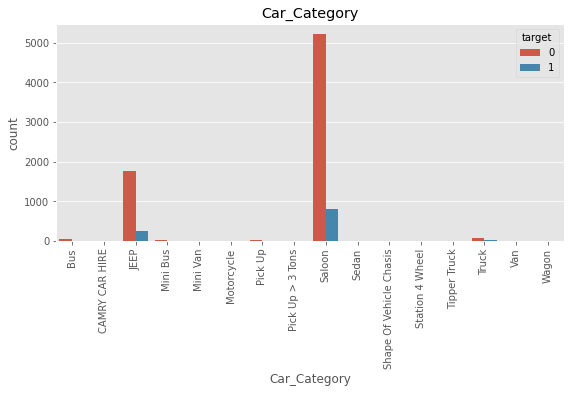

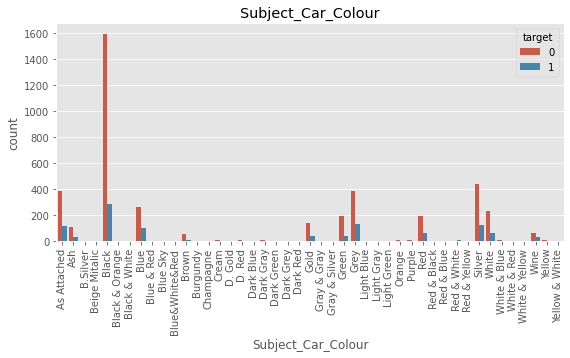

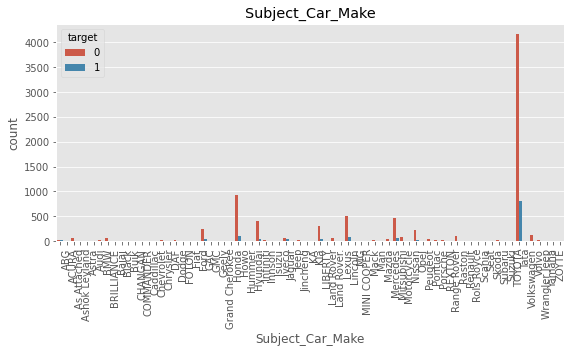

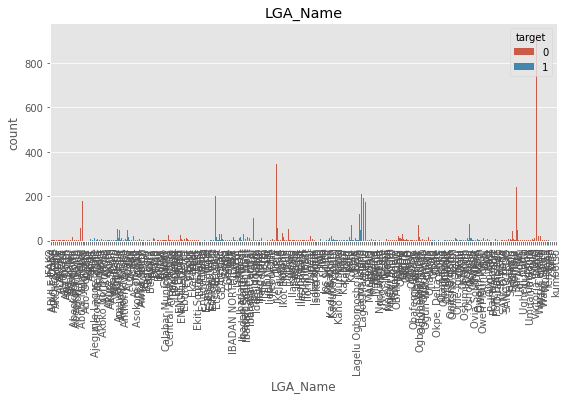

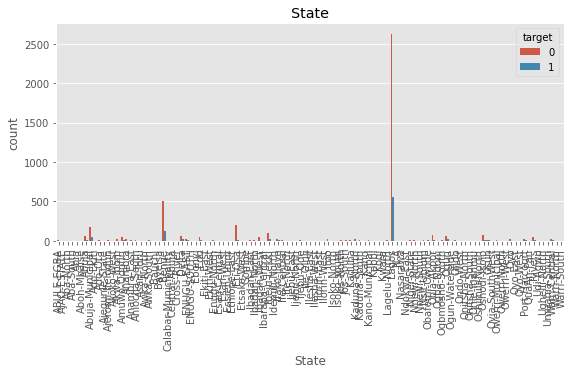

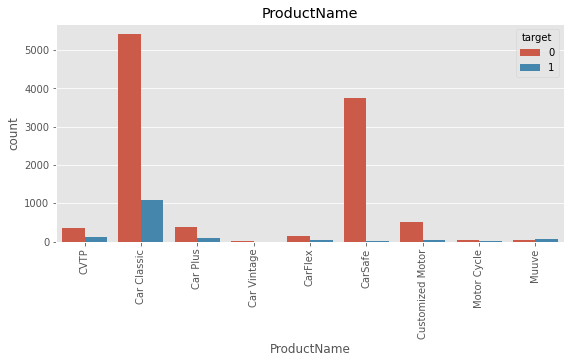

In [17]:
# Bivariate variables
def bivariate(data,cols):
    plt.style.use("ggplot")
    for column in cols:
        plt.figure(figsize=(20,4))
        plt.subplot(121)
        sns.countplot(data[column], hue=train["target"])
        plt.title(column)    
        plt.xticks(rotation=90)
bivariate(train,cat_c)        

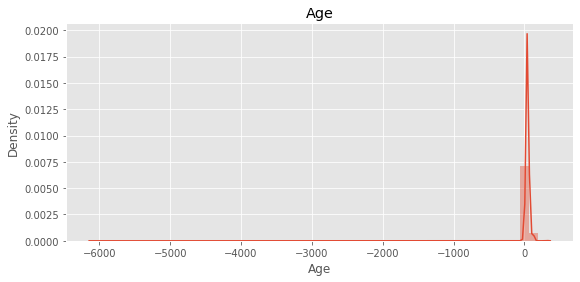

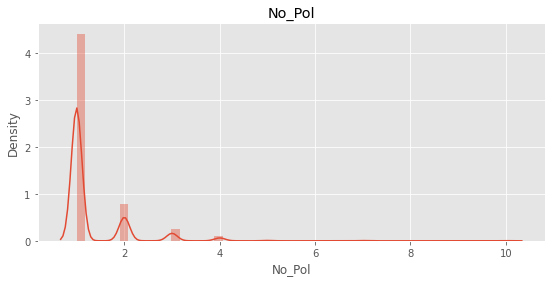

In [18]:
# Numeric variables

def numeric_eda(data):
    # plotting histogram for each numerical variable
    plt.style.use("ggplot")
    for column in ['Age', 'No_Pol']:
        plt.figure(figsize=(20,4))
        plt.subplot(121)
        sns.distplot(data[column], kde=True)
        plt.title(column)
numeric_eda(train)        

In [19]:
# Joining the train and test data

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (13281, 14)


In [20]:
# Checking the description of merged data

all_data.describe()

,Age,No_Pol,target
count,13281.000000,13281.000000,12079.000000
mean,42.375574,1.302763,0.120457
std,93.170951,0.723195,0.325509
min,-6099.000000,1.000000,0.000000
25%,35.000000,1.000000,0.000000
50%,41.000000,1.000000,0.000000
75%,50.000000,1.000000,0.000000
max,320.000000,10.000000,1.000000


#### Removing Outliers

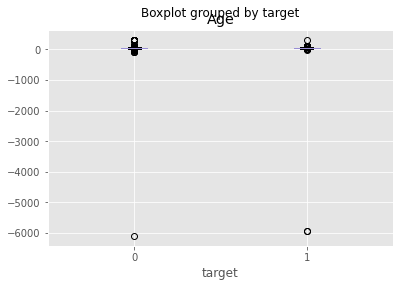

In [21]:
# Checking outliers by the target in the train dataset

train.boxplot('Age',by="target")

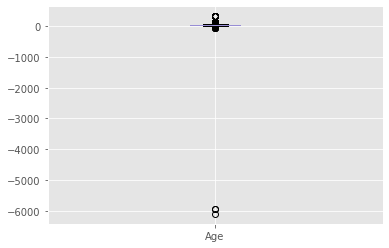

In [22]:
# Check outliers in the merged dataset

all_data.boxplot('Age')

In [23]:
# Compute interquantile range to calculate the boundaries

lower_boundries= []
upper_boundries= []
for i in ["Age"]:
    IQR= all_data[i].quantile(0.75) - all_data[i].quantile(0.25)
    print(all_data[i].quantile(0.5))
    lower_bound= all_data[i].quantile(0.25) - (1.5*IQR)
    upper_bound= all_data[i].quantile(0.75) + (1.5*IQR)
    
    print(i, ":", lower_bound, ",",  upper_bound)
    
    lower_boundries.append(lower_bound)
    upper_boundries.append(upper_bound)
lower_boundries[0]=18    


41.0
Age : 12.5 , 72.5


In [24]:
# Replace the all the outliers which is greater then upper boundary by upper boundary

all_data.loc[all_data['Age'] < lower_boundries[0], 'Age'] = int(lower_boundries[0])
all_data.loc[all_data['Age'] > upper_boundries[0], 'Age'] = int(upper_boundries[0])
all_data.describe()       

,Age,No_Pol,target
count,13281.000000,13281.000000,12079.000000
mean,42.548904,1.302763,0.120457
std,13.166686,0.723195,0.325509
min,18.000000,1.000000,0.000000
25%,35.000000,1.000000,0.000000
50%,41.000000,1.000000,0.000000
75%,50.000000,1.000000,0.000000
max,72.000000,10.000000,1.000000


## Feature Engineering

#### Reducing Categories in variables

In [25]:
# A function that reduces categories in variables

def reduce(column,n):
    others =  all_data[column].value_counts().index[n:]
    label = 'Other'
    all_data[column] =  all_data[column].replace(others, label)

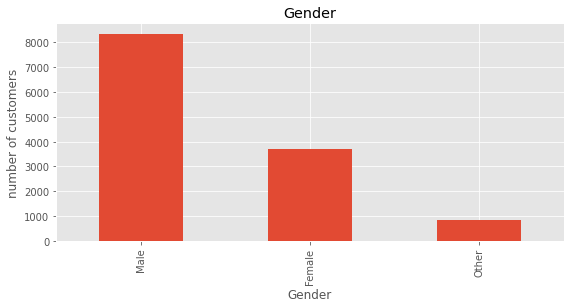

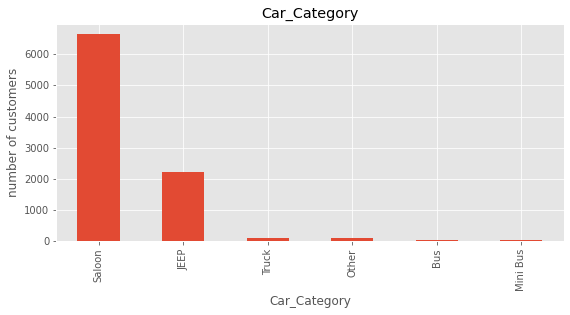

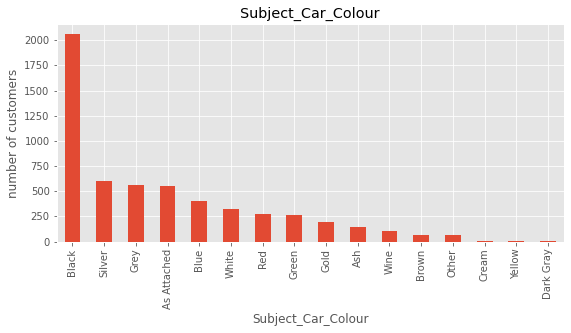

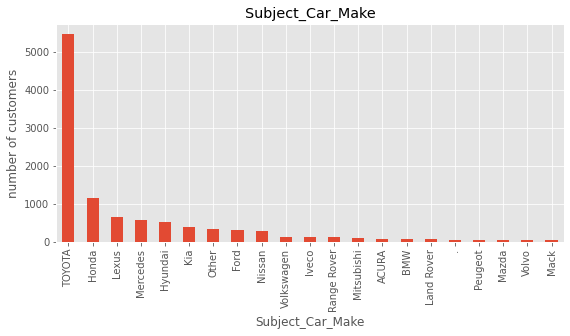

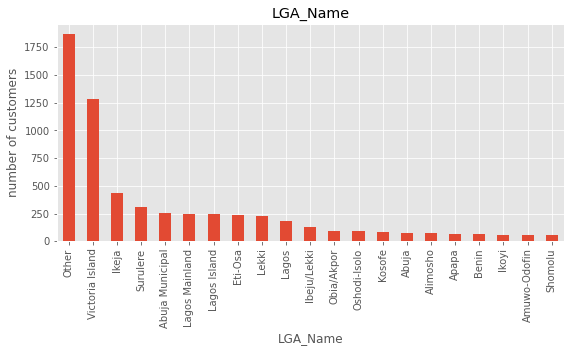

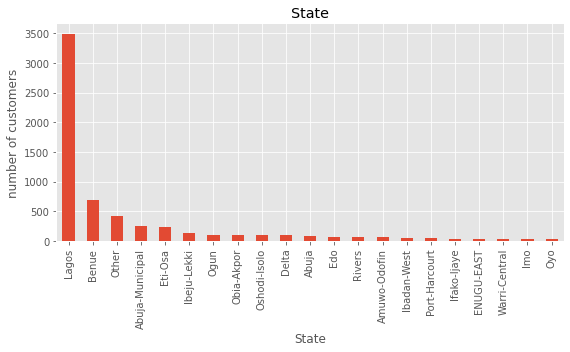

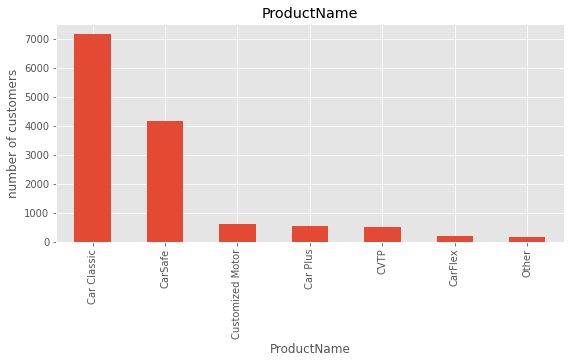

In [26]:
# Reducing the categories with the desired value

reduce('Gender',2)
reduce('Car_Category',5)
reduce('LGA_Name',20)
reduce('State',20)
reduce( 'Subject_Car_Make',20)
reduce( 'Subject_Car_Colour',15)
reduce( 'ProductName',6)
univariate_plot(all_data,cat_c) 

Deriving Duration of the Policy from the Policy End Date and Policy Start Date

In [27]:
#Duration of policy

all_data['Duration'] = all_data['Policy End Date']-all_data['Policy Start Date']
all_data['Duration']  = all_data['Duration'].dt.days
all_data['Duration'] =all_data['Duration'] .apply(lambda x: x/12)

In [28]:
all_data['policy_start']=all_data['Policy Start Date'].dt.to_period('Q').astype('category')

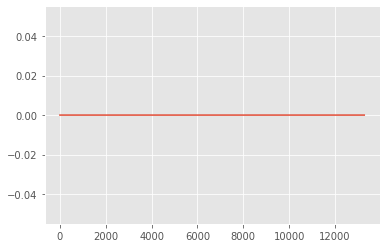

In [31]:
# Time after taking first policy
#Duration of policy

all_data['First_transaction'] = all_data['First Transaction Date']-all_data['Policy Start Date']
all_data['First_transaction']  = all_data['First_transaction'].dt.days
all_data['First_transaction'].plot()


#### Encoding categorical variables


In [32]:
# List of categorical variables 

cat_c

['Gender',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'LGA_Name',
 'State',
 'ProductName']

In [33]:
# Using Label Encoder to encode variables

from sklearn.preprocessing import LabelEncoder
#Encode categorical variables except null values
df_temp = all_data[cat_c].apply(LabelEncoder().fit_transform)
all_data[cat_c] = df_temp.where(~all_data[cat_c].isna(), all_data[cat_c])

In [34]:
# Confirming encoding

all_data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Duration,policy_start,First_transaction
0,ID_0040R73,2010-05-14,2011-05-13,1,30,2010-05-14,1,4,2,18,NaN,NaN,1,0.0,30.333333,2010Q2,0
1,ID_0046BNK,2010-11-29,2011-11-28,0,72,2010-11-29,1,1,9,18,NaN,NaN,1,1.0,30.333333,2010Q4,0
2,ID_005QMC3,2010-03-21,2011-03-20,1,43,2010-03-21,1,4,11,18,NaN,NaN,1,0.0,30.333333,2010Q1,0
3,ID_0079OHW,2010-08-21,2011-08-20,1,18,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,4,0.0,30.333333,2010Q3,0
4,ID_00BRP63,2010-08-29,2010-12-31,2,20,2010-08-29,3,NaN,NaN,NaN,11,12,6,1.0,10.333333,2010Q3,0


#### Splitting the data

In [35]:
train=all_data[:n_train]
test=all_data[n_train:]
# Check the shapes of the split dataset
print(train.shape)
print(test.shape)


(12079, 17)
(1202, 17)


In [38]:
cols= ['Gender', 'Age',
        'No_Pol', 'Car_Category','Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State',
       'ProductName', 'Duration' ,'target']
       



#### Fill missing values using KNN imputation

In [39]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)

# Applying KNNImputer onto the train dataset

train=train[cols]
imputed_X_train = pd.DataFrame(imputer.fit_transform(train))
imputed_X_train.columns = train.columns
train=imputed_X_train
train.isna().sum()

Gender                0
Age                   0
No_Pol                0
Car_Category          0
Subject_Car_Colour    0
Subject_Car_Make      0
LGA_Name              0
State                 0
ProductName           0
Duration              0
target                0
dtype: int64

In [40]:
# Applying KNNImputer onto the test set

test=test[cols[:-1]]
imputed_X_test = pd.DataFrame(imputer.fit_transform(test))
print(imputed_X_test.shape)

imputed_X_test.columns=test.columns
test=imputed_X_test
test.isna().sum()

(1202, 10)


Gender                0
Age                   0
No_Pol                0
Car_Category          0
Subject_Car_Colour    0
Subject_Car_Make      0
LGA_Name              0
State                 0
ProductName           0
Duration              0
dtype: int64

### Correlation 

#### Correlations amongst numerical variables

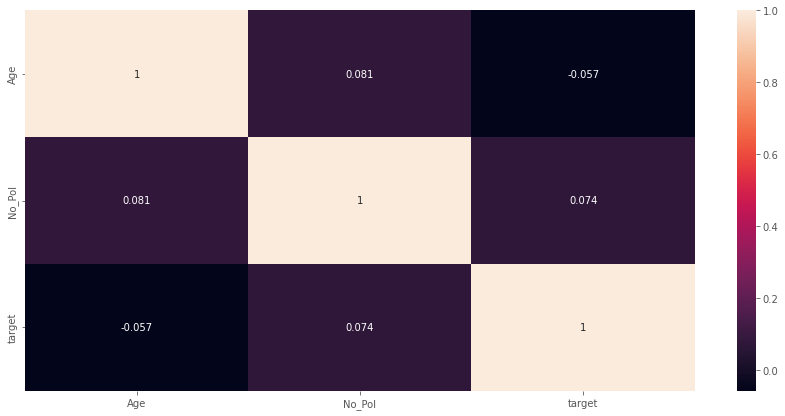

In [41]:
# Using a heatmap to visualize correlations amongst numerical variables

plt.figure(figsize=(15,7))
sns.heatmap(train[num_col].corr(), annot=True)

#### Correlation with target

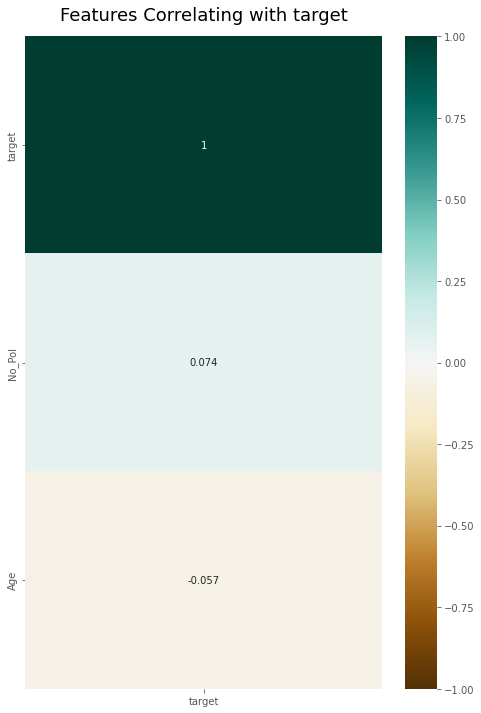

In [42]:
# Correlation with claims and no claims

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train[num_col].corr()[['target']].sort_values(by='target', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with target', fontdict={'fontsize':18}, pad=16);

#### Categorical correlations using Chi Squared and SelectKBest

In [43]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
chi2_selector = SelectKBest(chi2, k=len(cat_c))
X=train[cat_c]
y=train['target']
X_kbest = chi2_selector.fit(X, y)
'''used to compare observed results with expected results that is target variable and categorical variable '''
feature_score=pd.DataFrame({'score':X_kbest.scores_},index=X.columns)

feature_score.nlargest(n=len(cat_c),columns='score')


,score
ProductName,461.218430
Subject_Car_Colour,185.326095
Subject_Car_Make,48.082390
State,19.473994
LGA_Name,13.904773
Gender,7.211978
Car_Category,0.044977


In [44]:
# Select main columns to be used in training

main_cols = ['Gender', 'Age', 'No_Pol', 'Car_Category',
         'LGA_Name',
       'ProductName']
X = train[main_cols]
y = train.target
X.shape

(12079, 6)

#### Undersampling for imbalanced dataset

In [45]:
# The data is imbalanced dataset
# Defining undersample strategy

undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transform

X,y= undersample.fit_resample(X, y)

## Modeling

#### Splitting and assigning the test and train data to the predictor and predicted variables

In [46]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y)

Nearest Neighbors
F1 score on the X_test is: 0.7420212765957447
Linear SVM
F1 score on the X_test is: 0.7154105736782902
RBF SVM
F1 score on the X_test is: 0.6548387096774194
Gaussian Process
F1 score on the X_test is: 0.7265822784810126
Decision Tree
F1 score on the X_test is: 0.766398158803222
Random Forest
F1 score on the X_test is: 0.7623529411764706
Neural Net
F1 score on the X_test is: 0.7159904534606205
AdaBoost
F1 score on the X_test is: 0.7579462102689487
Naive Bayes
F1 score on the X_test is: 0.7199074074074074
LGBM
F1 score on the X_test is: 0.764629388816645
xgb
F1 score on the X_test is: 0.7652811735941321


BEST MODEL:  Decision Tree

F1 SCORE:  0.766398158803222



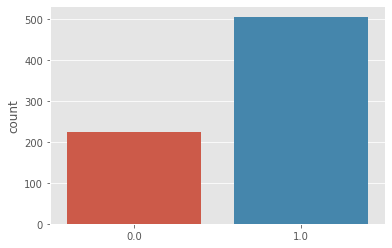

In [47]:
# Putting the classifiers together

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    'LGBM',
    'xgb'
]

classifiers = [
    KNeighborsClassifier(5),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    LGBMClassifier(),
    xgb.XGBClassifier(objective="binary:logistic", random_state=42)
]

# Iterate over classifiers

f=0
best_model=None
name_best=None
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1=f1_score(y_test, y_pred)
    if f1>f:
        f=f1
        best_model=clf
        name_best=name

    print(name)
    print(f'F1 score on the X_test is: {f1}')
print("")
print('='*80)   
print("") 
print("BEST MODEL: ",name_best)
print("")   
print("F1 SCORE: ",f)
print("")
y_pred =  best_model.predict(X_test) 
sns.countplot(y_pred);

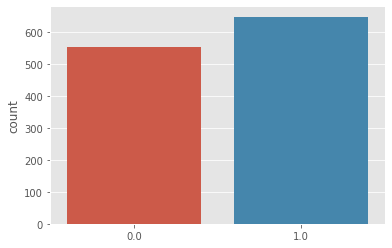

In [48]:
# Make prediction on the test set based on the best model

test1=test[main_cols]
predictions = best_model.predict(test1)
test_f['target']=predictions
test_f.head()

# Check the distribution of your predictions

sns.countplot(predictions);

In [49]:
# Checking the counts of the predictions 

test_f.target.value_counts()

1.0    648
0.0    554
Name: target, dtype: int64

In [50]:
# Create a csv file and upload to zindi 

test_f.to_csv('Baseline_ada_model75.csv', index = False)